# Working with Order Book Data: NASDAQ ITCH

The primary source of market data is the order book, which is continuously updated in real-time throughout the day to reflect all trading activity. Exchanges typically offer this data as a real-time service and may provide some historical data for free.

The trading activity is reflected in numerous messages about trade orders sent by market participants. These messages typically conform to the electronic Financial Information eXchange (FIX) communications protocol for real-time exchange of securities transactions and market data or a native exchange protocol. 

## Imports

In [24]:
from pathlib import Path
from collections import Counter
from datetime import timedelta
from datetime import datetime
from time import time
#%load_ext cudf.pandas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [3]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

### Set Data paths

We will store the download in a `data` subdirectory and convert the result to `hdf` format (discussed in the last section of chapter 2).

In [4]:
data_path = Path('/home/rick/Documents/ML4T/data/02_01') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'
date = '01302020'

## Build Order Book

In [5]:
stock = 'TSLA'
order_dict = {-1: 'sell', 1: 'buy'}

The parsed messages allow us to rebuild the order flow for the given day. The 'R' message type contains a listing of all stocks traded during a given day, including information about initial public offerings (IPOs) and trading restrictions.

Throughout the day, new orders are added, and orders that are executed and canceled are removed from the order book. The proper accounting for messages that reference orders placed on a prior date would require tracking the order book over multiple days, but we are ignoring this aspect here.

### Get all messages for given stock

The `get_messages()` function illustrates how to collect the orders for a single stock that affects trading (refer to the ITCH specification for details about each message):

In [6]:
# def get_messages(date, stock=stock):
#     """Collect trading messages for given stock"""
#     with pd.HDFStore(itch_store) as store:
#         stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
#         target = 'stock_locate = stock_locate'

#         data = {}
#         # trading message types
#         messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
#         for m in messages:
#             data[m] = store.select(m, where=target).drop('stock_locate', axis=1).assign(type=m)

#     order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
#     orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

#     for m in messages[2: -3]:
#         data[m] = data[m].merge(orders, how='left')

#     data['U'] = data['U'].merge(orders, how='left',
#                                 right_on='order_reference_number',
#                                 left_on='original_order_reference_number',
#                                 suffixes=['', '_replaced'])

#     data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
#     data['X']['shares'] = data['X']['cancelled_shares']
#     data['X'] = data['X'].dropna(subset=['price'])

#     data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
#     data['date'] = pd.to_datetime(date, format='%m%d%Y')
#     data.timestamp = data['date'].add(data.timestamp)
#     data = data[data.printable != 0]

#     drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
#                  'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
#                  'printable', 'date', 'cancelled_shares']
#     return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)
def get_messages(date, stock=stock):
    """Collect trading messages for given stock"""
    with pd.HDFStore(itch_store) as store:
        # Load the entire 'R' dataset
        stock_data = store.select('R')
        
        # Check if 'stock_locate' exists before filtering
        if 'stock_locate' in stock_data.columns:
            stock_locate = stock_data[stock_data['stock'] == stock].stock_locate.iloc[0]
        else:
            raise ValueError("'stock_locate' column not found in 'R' data.")

        target = f'stock_locate == {stock_locate}'

        data = {}
        # Trading message types
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
        for m in messages:
            # Load the data
            data[m] = store.select(m)
            
            # Apply the filter in Pandas if 'stock_locate' exists in this message type
            if 'stock_locate' in data[m].columns:
                data[m] = data[m].query(target).drop('stock_locate', axis=1)
            # Add a 'type' column
            data[m] = data[m].assign(type=m)

    # (Continue with the rest of the function)
    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

    for m in messages[2: -3]:
        data[m] = data[m].merge(orders, how='left')

    data['U'] = data['U'].merge(orders, how='left',
                                right_on='order_reference_number',
                                left_on='original_order_reference_number',
                                suffixes=['', '_replaced'])

    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    data['X']['shares'] = data['X']['cancelled_shares']
    data['X'] = data['X'].dropna(subset=['price'])

    data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
    data['date'] = pd.to_datetime(date, format='%m%d%Y')
    data.timestamp = data['date'].add(data.timestamp)
    data = data[data.printable != 0]

    drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
                 'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
                 'printable', 'date', 'cancelled_shares']
    return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)



In [7]:
messages = get_messages(date=date)
#messages.info(null_counts=True)
messages.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 2966792 entries, 0 to 2966791
Data columns (total 9 columns):
 #   Column              Dtype
---  ------              -----
 0   timestamp           datetime64[ns]
 1   buy_sell_indicator  float64
 2   shares              float64
 3   price               float64
 4   type                object
 5   executed_shares     float64
 6   execution_price     float64
 7   shares_replaced     float64
 8   price_replaced      float64
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 195.2+ MB


In [8]:
with pd.HDFStore(order_book_store) as store:
    key = f'{stock}/messages'
    store.put(key, messages)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: /home/rick/Documents/ML4T/data/02_01/order_book.h5
/TSLA/buy                 frame_table  (typ->appendable,nrows->39079673,ncols->2,indexers->[index],dc->[])
/TSLA/messages            frame        (shape->[2966792,9])                                               
/TSLA/sell                frame_table  (typ->appendable,nrows->41662713,ncols->2,indexers->[index],dc->[])
/TSLA/trades              frame        (shape->[481952,3])                                                


### Combine Trading Records

Reconstructing successful trades, that is, orders that are executed as opposed to those that were canceled from trade-related message types, C, E, P, and Q, is relatively straightforward:

In [9]:
def get_trades(m):
    """Combine C, E, P and Q messages into trading records"""
    trade_dict = {'executed_shares': 'shares', 'execution_price': 'price'}
    cols = ['timestamp', 'executed_shares']
    trades = pd.concat([m.loc[m.type == 'E', cols + ['price']].rename(columns=trade_dict),
                        m.loc[m.type == 'C', cols + ['execution_price']].rename(columns=trade_dict),
                        m.loc[m.type == 'P', ['timestamp', 'price', 'shares']],
                        m.loc[m.type == 'Q', ['timestamp', 'price', 'shares']].assign(cross=1),
                        ], sort=False).dropna(subset=['price']).fillna(0)
    return trades.set_index('timestamp').sort_index().astype(int)

In [10]:
trades = get_trades(messages)
print(trades.info())

<class 'cudf.core.dataframe.DataFrame'>
DatetimeIndex: 481952 entries, 2020-01-30 04:00:04.437803704 to 2020-01-30 19:59:50.553615744
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   shares  481952 non-null  int64
 1   price   481952 non-null  int64
 2   cross   481952 non-null  int64
dtypes: int64(3)
memory usage: 14.7 MB
None


In [11]:
with pd.HDFStore(order_book_store) as store:
    store.put(f'{stock}/trades', trades)

### Create Orders

The order book keeps track of limit orders, and the various price levels for buy and sell orders constitute the depth of the order book. To reconstruct the order book for a given level of depth requires the following steps:


The `add_orders()` function accumulates sell orders in ascending, and buy orders in descending order for a given timestamp up to the desired level of depth:

In [12]:
def add_orders(orders, buysell, nlevels):
    """Add orders up to desired depth given by nlevels;
        sell in ascending, buy in descending order
    """
    new_order = []
    items = sorted(orders.copy().items())
    if buysell == 1:
        items = reversed(items)  
    for i, (p, s) in enumerate(items, 1):
        new_order.append((p, s))
        if i == nlevels:
            break
    return orders, new_order

In [13]:
def save_orders(orders, append=False):
    cols = ['price', 'shares']
    for buysell, book in orders.items():
        df = (pd.concat([pd.DataFrame(data=data,
                                     columns=cols)
                         .assign(timestamp=t) 
                         for t, data in book.items()]))
        key = f'{stock}/{order_dict[buysell]}'
        df.loc[:, ['price', 'shares']] = df.loc[:, ['price', 'shares']].astype(int)
        with pd.HDFStore(order_book_store) as store:
            if append:
                store.append(key, df.set_index('timestamp'), format='t')
            else:
                store.put(key, df.set_index('timestamp'))

We iterate over all ITCH messages and process orders and their replacements as required by the specification (this can take a while):

In [14]:
order_book = {-1: {}, 1: {}}
current_orders = {-1: Counter(), 1: Counter()}
message_counter = Counter()
nlevels = 100

start = time()
for message in messages.itertuples():
    i = message[0]
    if i % 1e5 == 0 and i > 0:
        print(f'{i:,.0f}\t\t{format_time(time() - start)}')
        save_orders(order_book, append=True)
        order_book = {-1: {}, 1: {}}
        start = time()
    if np.isnan(message.buy_sell_indicator):
        continue
    message_counter.update(message.type)

    buysell = message.buy_sell_indicator
    price, shares = None, None

    if message.type in ['A', 'F', 'U']:
        price = int(message.price)
        shares = int(message.shares)

        current_orders[buysell].update({price: shares})
        current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
        order_book[buysell][message.timestamp] = new_order

    if message.type in ['E', 'C', 'X', 'D', 'U']:
        if message.type == 'U':
            if not np.isnan(message.shares_replaced):
                price = int(message.price_replaced)
                shares = -int(message.shares_replaced)
        else:
            if not np.isnan(message.price):
                price = int(message.price)
                shares = -int(message.shares)

        if price is not None:
            current_orders[buysell].update({price: shares})
            if current_orders[buysell][price] <= 0:
                current_orders[buysell].pop(price)
            current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
            order_book[buysell][message.timestamp] = new_order

100,000		00:00:17
200,000		00:00:27
300,000		00:01:02
400,000		00:01:01
500,000		00:00:58
600,000		00:00:58
700,000		00:00:57
800,000		00:00:60
900,000		00:01:03
1,000,000		00:00:60
1,100,000		00:00:57
1,200,000		00:00:56
1,300,000		00:00:58
1,400,000		00:01:01
1,500,000		00:01:04
1,600,000		00:01:02
1,700,000		00:00:59
1,800,000		00:00:58
1,900,000		00:00:57
2,000,000		00:00:57
2,100,000		00:00:55
2,200,000		00:00:58
2,300,000		00:00:55
2,400,000		00:00:55
2,500,000		00:00:53
2,600,000		00:00:51
2,700,000		00:01:02
2,800,000		00:00:60
2,900,000		00:01:06


In [15]:
message_counter = pd.Series(message_counter)
print(message_counter)

A     833764
D    1428576
E     359772
P     119942
X       4436
F      10870
U      15508
C       2232
dtype: int64


In [16]:
with pd.HDFStore(order_book_store) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: /home/rick/Documents/ML4T/data/02_01/order_book.h5
/TSLA/buy                 frame_table  (typ->appendable,nrows->78159246,ncols->2,indexers->[index],dc->[])
/TSLA/messages            frame        (shape->[2966792,9])                                               
/TSLA/sell                frame_table  (typ->appendable,nrows->83325426,ncols->2,indexers->[index],dc->[])
/TSLA/trades              frame        (shape->[481952,3])                                                


## Order Book Depth

In [17]:
with pd.HDFStore(order_book_store) as store:
    buy = store[f'{stock}/buy'].reset_index().drop_duplicates()
    sell = store[f'{stock}/sell'].reset_index().drop_duplicates()

### Price to Decimals

In [18]:
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

### Remove outliers

In [19]:
percentiles = [.01, .02, .1, .25, .75, .9, .98, .99]
pd.concat([buy.price.describe(percentiles=percentiles).to_frame('buy'),
           sell.price.describe(percentiles=percentiles).to_frame('sell')], axis=1)

,buy,sell
count,3.907927e+07,4.166221e+07
mean,6.392214e+02,6.303454e+02
std,9.720250e+00,4.972581e+01
min,3.560000e+02,6.183300e+02
1%,6.144200e+02,6.193200e+02
2%,6.172000e+02,6.193900e+02
10%,6.275000e+02,6.206400e+02
25%,6.370900e+02,6.239200e+02
50%,6.410000e+02,6.292400e+02
75%,6.447600e+02,6.346300e+02


In [20]:
buy = buy[buy.price > buy.price.quantile(.01)]
sell = sell[sell.price < sell.price.quantile(.99)]

In [21]:
print(buy)


                             timestamp   price  shares
14       2020-01-30 04:00:00.182504155  634.12     200
19       2020-01-30 04:00:00.182649560  640.20     200
20       2020-01-30 04:00:00.182649560  634.12     200
25       2020-01-30 04:00:00.368661156  640.20     200
26       2020-01-30 04:00:00.368661156  638.10     200
...                                ...     ...     ...
39079668 2020-01-30 16:00:01.625226827  621.89      20
39079669 2020-01-30 16:00:01.625226827  621.68     140
39079670 2020-01-30 16:00:01.625226827  621.46       4
39079671 2020-01-30 16:00:01.625226827  621.15      20
39079672 2020-01-30 16:00:01.625226827  621.05      20

[38688316 rows x 3 columns]


### Buy-Sell Order Distribution

The number of orders at different price levels, highlighted in the following screenshot using different intensities for buy and sell orders, visualizes the depth of liquidity at any given point in time.

The distribution of limit order prices was weighted toward buy orders at higher prices.

In [22]:
market_open='0930'
market_close = '1600'

KeyError: 'edges'

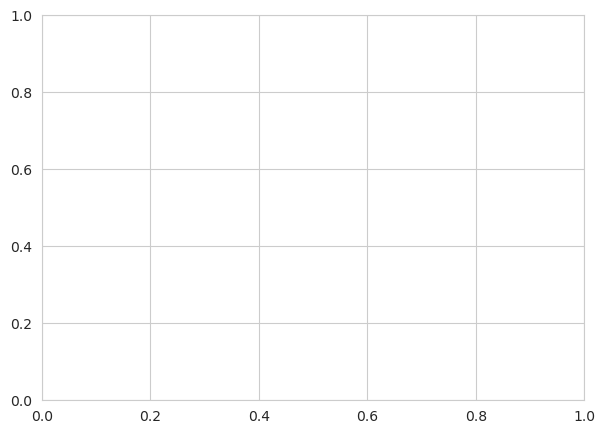

In [25]:
# fig, ax = plt.subplots(figsize=(7,5))
# hist_kws = {'linewidth': 1, 'alpha': .5}
# sns.distplot(buy[buy.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price, 
#              ax=ax, label='Buy', kde=False, hist_kws=hist_kws)
# sns.distplot(sell[sell.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price, 
#              ax=ax, label='Sell', kde=False, hist_kws=hist_kws)

# ax.legend(fontsize=10)
# ax.set_title('Limit Order Price Distribution')
# ax.set_yticklabels([f'{int(y/1000):,}' for y in ax.get_yticks().tolist()])
# ax.set_xticklabels([f'${int(x):,}' for x in ax.get_xticks().tolist()])
# ax.set_xlabel('Price')
# ax.set_ylabel('Shares (\'000)')
# sns.despine()
# fig.tight_layout();

#######################
### Fixed code below, manually creates 
### the legend by passing the labels directly to ax.legend()
#######################

fig, ax = plt.subplots(figsize=(7, 5))
hist_kws = {'linewidth': 1, 'alpha': .5}

# Plot the histograms and store the return values to use for the legend
buy_hist = sns.histplot(buy[buy.price.between(630, 640)]
                        .set_index('timestamp')
                        .between_time(market_open, market_close).price, 
                        ax=ax, label='Buy', bins=30, kde=False, 
                        linewidth=hist_kws['linewidth'], alpha=hist_kws['alpha'], color='blue')

sell_hist = sns.histplot(sell[sell.price.between(630, 640)]
                         .set_index('timestamp')
                         .between_time(market_open, market_close).price, 
                         ax=ax, label='Sell', bins=30, kde=False, 
                         linewidth=hist_kws['linewidth'], alpha=hist_kws['alpha'], color='orange')

# Manually create the legend using the labels for the plotted data
ax.legend(labels=['Buy', 'Sell'], fontsize=10)

ax.set_title('Limit Order Price Distribution')

# Set ticks before setting the tick labels to avoid warnings
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{int(y/1000):,}' for y in ax.get_yticks()])

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([f'${int(x):,}' for x in ax.get_xticks()])

ax.set_xlabel('Price')
ax.set_ylabel('Shares (\'000)')

sns.despine()

fig.tight_layout()


### Order Book Depth

In [ ]:
utc_offset = timedelta(hours=4)
depth = 100

In [ ]:
buy_per_min = (buy
               .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
               .shares
               .sum()
               .apply(np.log)
               .to_frame('shares')
               .reset_index('price')
               .between_time(market_open, market_close)
               .groupby(level='timestamp', as_index=False, group_keys=False)
               .apply(lambda x: x.nlargest(columns='price', n=depth))
               .reset_index())
buy_per_min.timestamp = buy_per_min.timestamp.add(utc_offset).astype(int)
buy_per_min.info()

In [ ]:
sell_per_min = (sell
                .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
                .shares
                .sum()
                .apply(np.log)
                .to_frame('shares')
                .reset_index('price')
                .between_time(market_open, market_close)
                .groupby(level='timestamp', as_index=False, group_keys=False)
                .apply(lambda x: x.nsmallest(columns='price', n=depth))
                .reset_index())

sell_per_min.timestamp = sell_per_min.timestamp.add(utc_offset).astype(int)
sell_per_min.info()

In [ ]:
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0].between_time(market_open, market_close)

trades_per_min = (trades
                  .resample('Min')
                  .agg({'price': 'mean', 'shares': 'sum'}))
trades_per_min.index = trades_per_min.index.to_series().add(utc_offset).astype(int)
trades_per_min.info()

The following plots the evolution of limit orders and prices throughout the trading day: the dark line tracks the prices for executed trades during market hours, whereas the red and blue dots indicate individual limit orders on a per-minute basis (see notebook for details)

In [ ]:
# sns.set_style('white')
# fig, ax = plt.subplots(figsize=(14, 6))

# buy_per_min.plot.scatter(x='timestamp',
#                          y='price', 
#                          c='shares', 
#                          ax=ax, 
#                          colormap='Blues', 
#                          colorbar=False, 
#                          alpha=.25)

# sell_per_min.plot.scatter(x='timestamp',
#                           y='price', 
#                           c='shares', 
#                           ax=ax, 
#                           colormap='Reds', 
#                           colorbar=False, 
#                           alpha=.25)

# title = f'TSLA | {date} | Buy & Sell Limit Order Book | Depth = {depth}'
# trades_per_min.price.plot(figsize=(14, 8), 
#                           c='k', 
#                           ax=ax, 
#                           lw=2, 
#                           title=title)

# xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
# ax.set_xticklabels(xticks)

# ax.set_xlabel('')
# ax.set_ylabel('Price', fontsize=12)

# red_patch = mpatches.Patch(color='red', label='Sell')
# blue_patch = mpatches.Patch(color='royalblue', label='Buy')

# plt.legend(handles=[red_patch, blue_patch])
# sns.despine()
# fig.tight_layout()

#############################
######## REVISED CODE FOLLOWS
#############################

## Check Data - uncomment when needed.
# print(buy_per_min.columns)
# print(sell_per_min.columns)
# print(trades_per_min.columns)

import matplotlib.dates as mdates

# Ensure 'timestamp' column is in datetime format for buy_per_min and sell_per_min
buy_per_min['timestamp'] = pd.to_datetime(buy_per_min['timestamp'], unit='ns')
sell_per_min['timestamp'] = pd.to_datetime(sell_per_min['timestamp'], unit='ns')

# Convert index of trades_per_min to datetime if not already
# trades_per_min.index = pd.to_datetime(trades_per_min.index, unit='ns')

# Plot the scatter for buy and sell data
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14, 6))


# Plot the trades_per_min, using its index for the x-axis
title = f'TSLA | {date} | Buy & Sell Limit Order Book | Depth = {depth}'
#trades_per_min.plot(x=trades_per_min.index, y='price', ax=ax, c='k', lw=2, title=title)

trades_per_min.price.plot(figsize=(14, 8), 
                           c='k', 
                           ax=ax, 
                           lw=2, 
                           title=title)


buy_per_min.plot.scatter(x='timestamp',
                         y='price', 
                         c='shares',
                         s=50,
                         ax=ax, 
                         colormap='Blues', 
                         colorbar=False, 
                         alpha=.25)

sell_per_min.plot.scatter(x='timestamp',
                          y='price', 
                          c='shares',
                          s=50,
                          ax=ax, 
                          colormap='Reds', 
                          colorbar=False, 
                          alpha=.25)
# Format x-axis to display datetime in HH:MM format
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.set_xticks(ax.get_xticks())
xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

# Set x-ticks before setting the labels
# ax.set_xticks(ax.get_xticks())
# xticks = [mdates.num2date(ts).strftime('%H:%M') for ts in ax.get_xticks()]
# ax.set_xticklabels(xticks)

ax.set_xlabel('')
ax.set_ylabel('Price', fontsize=12)

# Add legend manually
red_patch = mpatches.Patch(color='red', label='Sell')
blue_patch = mpatches.Patch(color='royalblue', label='Buy')
plt.legend(handles=[red_patch, blue_patch])

sns.despine()
fig.tight_layout()
